In [12]:
import sys
import os
import matplotlib.pyplot as plt
import math
import random
import cv2
project_root = os.path.abspath(os.path.join('..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.patch_utils import extract_patches
from src.feature_extractor import *
from src.search_engine import FaissSearch
from src.visualization import *

print("Imports successful!")

Imports successful!


In [8]:
# Configuration
IMAGE_PATH = '../data/raw_maps/sample_venice_map_3.jpg'
# PATCH_SIZE = (224, 224)
# STRIDE = (112, 112)  # 50% overlap
PATCH_SIZE = (112, 112)
STRIDE = (56, 56)  # 50% overlap
K_NEIGHBORS = 20  # Number of search results
MODEL = 'openai/clip-vit-base-patch32'
MODEL = 'PE-Core-B16-224'
FEATURE_DIM = 512  # Feature dimension for CLIP
FEATURE_DIM = 1024  # Feature dimension for PE

In [3]:
print(f"Loading map: {IMAGE_PATH}")
if not os.path.exists(IMAGE_PATH):
    raise FileNotFoundError(f"Not found: {IMAGE_PATH}")

original_map = Image.open(IMAGE_PATH).convert("RGB")
original_map_shape = original_map.size[::-1]

Loading map: ../data/raw_maps/sample_venice_map_3.jpg


Extracting patches from ../data/raw_maps/sample_venice_map_3.jpg...


Patching Image: 100%|██████████| 4171/4171 [00:00<00:00, 14423.53it/s]

Successfully extracted 4171 patches.


In [10]:
# Feature Extraction
extractor = PEFeatureExtractor(model_name=MODEL)
image_features = extractor.extract_image_features(patch_images)
print(f"\nFeature extraction complete. Feature matrix shape: {image_features.shape}")

FeatureExtractor (Perception Encoder) using device: cuda
Missing keys for loading model: []
Unexpected keys for loading model: []
模型 PE-Core-B16-224 加载成功。图像大小: 224px
Extracting image features using PE-Core-B16-224...


Extracting PE Features: 100%|██████████| 66/66 [07:55<00:00,  7.20s/it]



Feature extraction complete. Feature matrix shape: (4171, 1024)


FAISS: No GPU support detected. Using CPU.
Building index with 4171 vectors...
Index built. Total vectors in index: 4171


--- Demo 1: Image-to-Image Search ---


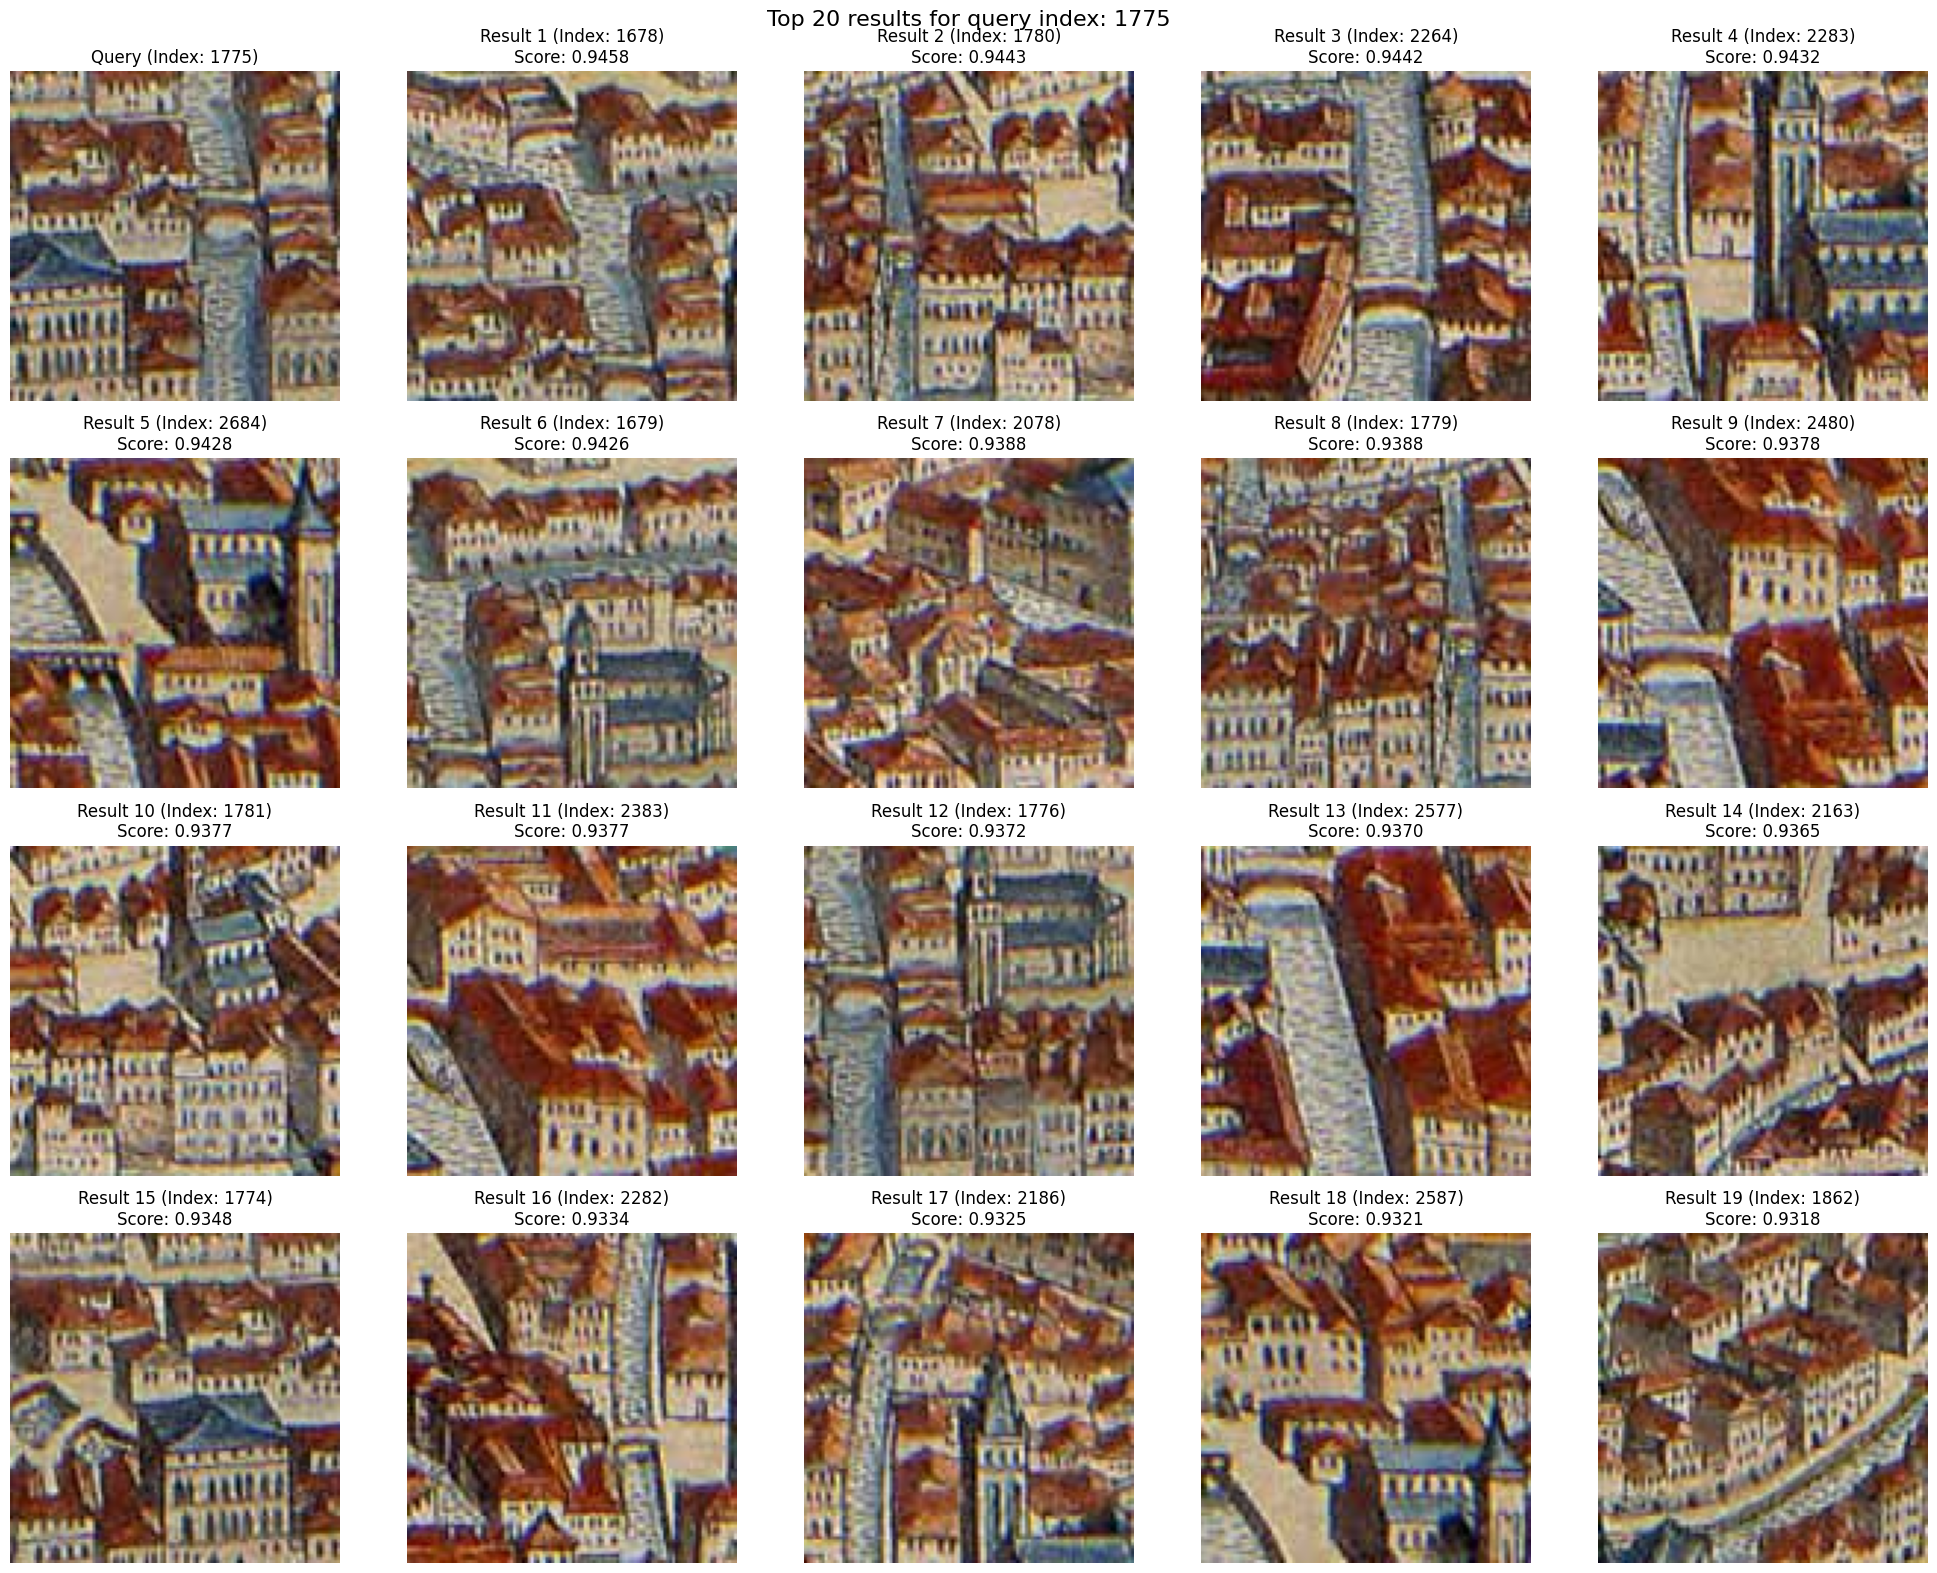

In [15]:
## Search Demo 1 - Image-to-Image
print("--- Demo 1: Image-to-Image Search ---")

# Randomly select a tile as the query
query_index = random.randint(0, len(patches_data) - 1)
query_patch = patches_data[query_index]['patch']
query_vector = np.expand_dims(image_features[query_index], axis=0)  # Keep 2D shape

# Execute the search
distances, indices = search_engine.search(query_vector, k=K_NEIGHBORS)

# Visualization parameters
COLS_PER_ROW = 5
ROWS = math.ceil(K_NEIGHBORS / COLS_PER_ROW)

# Create a grid (e.g., 3 rows × 5 columns)
fig, axes = plt.subplots(ROWS, COLS_PER_ROW, figsize=(20, 4 * ROWS))
fig.suptitle(f"Top {K_NEIGHBORS} results for query index: {query_index}", fontsize=16)

axes_flat = axes.flat

for i, (idx, dist) in enumerate(zip(indices[0], distances[0])):
    ax = axes_flat[i]
    result_patch = patches_data[idx]['patch']

    # Highlight the query image
    if i == 0:
        ax.imshow(result_patch)
        ax.set_title(f"Query (Index: {idx})")
    else:
        ax.imshow(result_patch)
        ax.set_title(f"Result {i} (Index: {idx})\nScore: {dist:.4f}")
    ax.axis('off')

# Hide extra empty subplots if K is not a multiple of 5
for i in range(len(indices[0]), len(axes_flat)):
    axes_flat[i].axis('off')

plt.tight_layout()
plt.show()



--- Demo 3: Text-to-Image Search (Heatmap Visualization) ---
Query: 'arched bridge over the river'
Searching for Top 100 results...
Found 100 matches above threshold 0.0.
Generating heatmap...
Creating heatmap array...
Applying Gaussian blur with kernel (31, 31)...
Applying heatmap overlay...
Applying heatmap shadow...
Heatmap result saved to: output/heatmap_overlay_result_arched_bridge_over_the_river.png
Heatmap result saved to: output/heatmap_shadow_result_arched_bridge_over_the_river.png
Heatmap result saved to: output/heatmap_colorize_result_arched_bridge_over_the_river.png
Heatmap result saved to: output/heatmap_hsv_colorize_result_arched_bridge_over_the_river.png


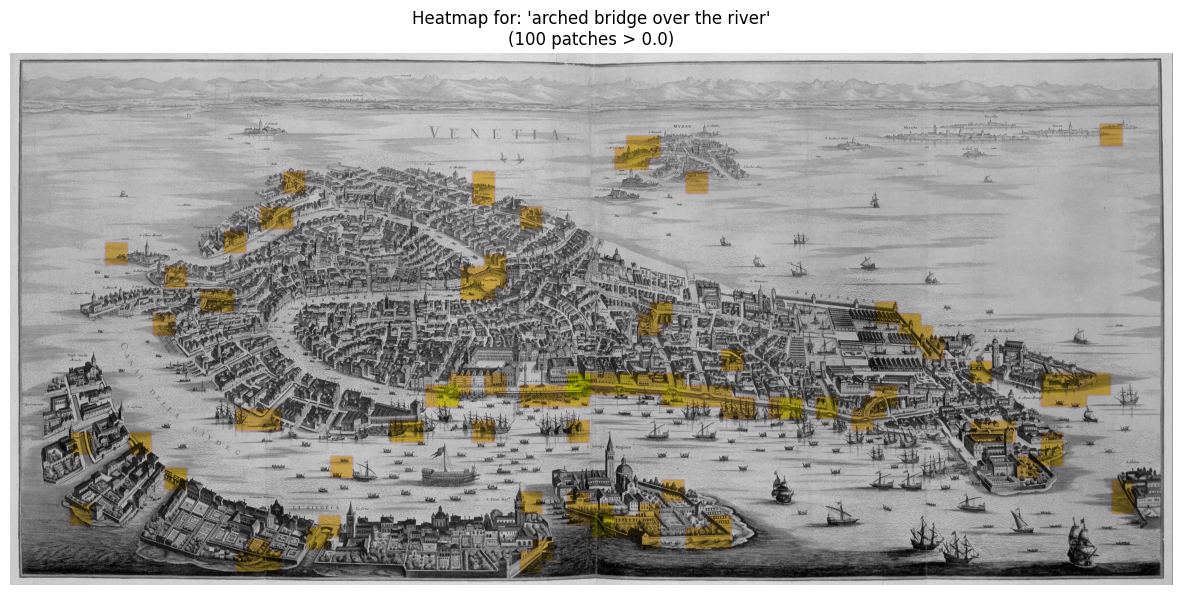

In [10]:
print(f"\n--- Demo 3: Text-to-Image Search (Heatmap Visualization) ---")
print(f"Query: '{TEXT_QUERY}'")

K_RESULTS_HEATMAP = 100       # Retrieve more results to generate a good heatmap
MIN_SCORE_THRESHOLD = 0.0   # Threshold: only show results with a score above this on the heatmap

print(f"Searching for Top {K_RESULTS_HEATMAP} results...")
distances, indices = search_engine.search(text_query_vector, k=K_RESULTS_HEATMAP)

if distances is None:
    print("Search failed.")
else:
    # Create an all-zero array and fill in scores only at the locations of the matching patches.
    sparse_scores = np.zeros(len(patch_images), dtype=np.float32)
    valid_results = 0
    
    for idx, score in zip(indices[0], distances[0]):
        if score >= MIN_SCORE_THRESHOLD:
            sparse_scores[idx] = score
            valid_results += 1
    
    print(f"Found {valid_results} matches above threshold {MIN_SCORE_THRESHOLD}.")

    if valid_results > 0:
        # Create heatmap
        print("Generating heatmap...")
        heatmap_array = create_heatmap(
            image_shape=original_map_shape, # (h, w)
            patch_coords=patch_coords,      # list of (x, y)
            scores=sparse_scores,           # scores
            patch_size=PATCH_SIZE
        )

        print("Applying heatmap overlay...")
        final_image_overlay = apply_heatmap_overlay(IMAGE_PATH, heatmap_array)
        print("Applying heatmap shadow...")
        final_image_shadow = apply_heatmap_shadow(
            IMAGE_PATH,
            heatmap_array,
            shadow_color=(70, 70, 70),
            contrast_factor=4,
            max_shadow_opacity=0.8
        )

        final_image_colorize = apply_heatmap_colorize(
            IMAGE_PATH,
            heatmap_array,
            colormap=cv2.COLORMAP_INFERNO,
            contrast_factor=3
        )

        final_image_hsv_colorize = apply_heatmap_hsv_colorize(
            IMAGE_PATH,
            heatmap_array,
            colormap=cv2.COLORMAP_INFERNO,
            contrast_factor=3
        )
        
        output_filename = f"output/heatmap_overlay_result_{TEXT_QUERY.replace(' ', '_')}.png"
        final_image_overlay.save(output_filename)
        print(f"Heatmap result saved to: {output_filename}")

        output_filename = f"output/heatmap_shadow_result_{TEXT_QUERY.replace(' ', '_')}.png"
        final_image_shadow.save(output_filename)
        print(f"Heatmap result saved to: {output_filename}")

        output_filename = f"output/heatmap_colorize_result_{TEXT_QUERY.replace(' ', '_')}.png"
        final_image_colorize.save(output_filename)
        print(f"Heatmap result saved to: {output_filename}")

        output_filename = f"output/heatmap_hsv_colorize_result_{TEXT_QUERY.replace(' ', '_')}.png"
        final_image_hsv_colorize.save(output_filename)
        print(f"Heatmap result saved to: {output_filename}")

        # Visualize
        plt.figure(figsize=(15, 15))
        plt.imshow(final_image_hsv_colorize)
        plt.title(f"Heatmap for: '{TEXT_QUERY}'\n({valid_results} patches > {MIN_SCORE_THRESHOLD})")
        plt.axis('off')
        plt.show()
    else:
        print(f"No matches found above threshold {MIN_SCORE_THRESHOLD}. Heatmap not generated.")
        print("Hint: Try a broader query or lower the MIN_SCORE_THRESHOLD threshold.")